In [153]:
%matplotlib inline

# Module 13 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Module 4, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

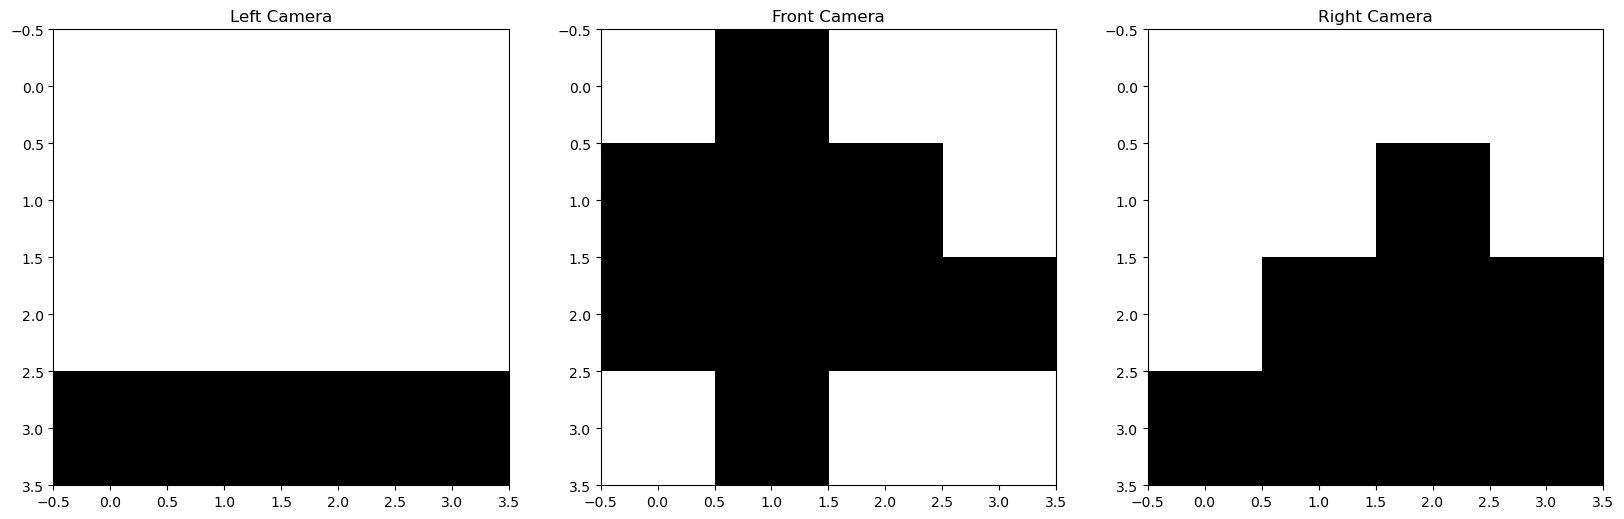

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.


## The Assignment

In Assignment 12, we applied a logistic regression to determine if something was "hills" or "not hills". For this programming assignment your task is to write an artificial neural network that determines what kind of terrain it is. This is a multi-class problem.

For a starting point, you can refer to Pseudocode and the Self-Check.

## Data

As before, we have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [155]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [156]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

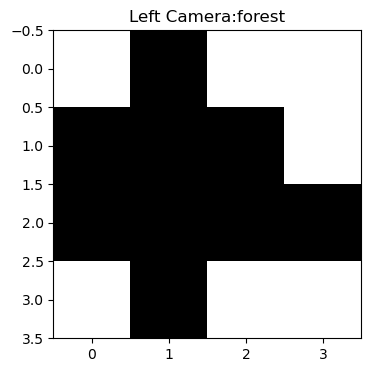

In [157]:
view_sensor_image( clean_data[ "forest"][0])

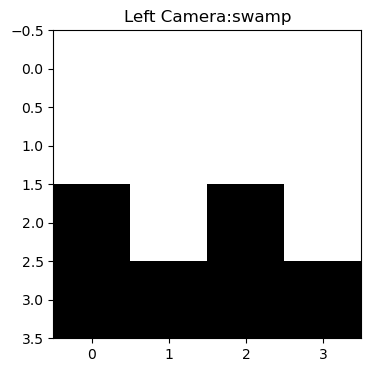

In [158]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [159]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

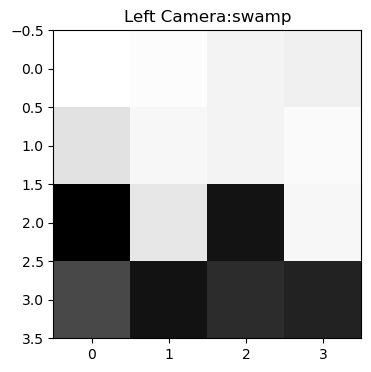

In [160]:
view_sensor_image( blur( clean_data["swamp"][0]))

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`

### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, an ANN that determines if a sensor image is hills, swamp, forest or plains.

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes for each class. This means you should probably generate training data with, say, 100 of each type.

But what do we do about the class label with the neural network?

In this case, we can do "one hot". Instead of `generate_data` outputing a single 0 or 1, it should output a vector of 0's and 1's so that $y$ is now a vector as well as $x$. We can use the first position for hill, the second for swamp, the third for forest and the fourth for plains:

```
[0, 1, 0, 0]
```

what am I? swamp.

Unlike logistic regression, you should set the *biases* inside the neural network (the implict $x_0$ = 1) because there are going to be lot of them (one for every hidden and output node).

`generate_data` now only needs to take how many you want of each class:

`generate_data( clean_data, 100)`

generates 100 hills, 100 swamp, 100 forest, 100 plains and transforms $y$ into the respective "one hot" encoding. You can use the code from Module 12 as a starting point.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the ANN. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

You should add a parameter to indicate how many nodes the hidden layer should have.

When verbose is True, you should print out the error so you can see that it is getting smaller.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the neural network. The hidden layer will be one vector of thetas for each hidden node. And the output layer will have its own thetas, one for each output (4 in this case). Return it as a Tuple: (List of List, List of List).

### `apply_model`

`apply_model` takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. Note that unlike the logistic regression, the threshold for 1 is not 0.5 but which value is largest (0.98 in this case).

If the data is labeled, you will return a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). For a single data point, you'll have the pairs of actual values [(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification. Then you have a List of *those*, one for each observation.

###  simple evaluation

We have an "unlimited" supply of data so we'll just generate a training set and then a test set and see how well our neural network does. Use the error rate (incorrect classifications/total examples) for your evaluation metric. We'll learn about more sophisticated 

1. generate training set (how many do you think you need?)
2. generate test set (how many is a good "test" of the network you built?)
3. loop over [2, 4, 8] hidden nodes:
    1. train model and apply to train data, calculate error rate.
    2. apply to test data and calculate error rate.
    3. print error rate
    
Which number of hidden nodes did best?

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (you may want to make a copy first)**

In [161]:
def error_rate(evaluation):
    error = 0
    count = 0
    for i in evaluation:
        count += 1
        for j in i:
            if j[0]!=j[1]:
                error+=1
                break
    return error*100/count

In [162]:
def make_prediction_on_data_point(ANN,data_point):
    hidden_size = len(ANN[0])
    output_size = len(ANN[1])
    final_hidden = []
    theta_values = []
    final_output = []
    output_values = []
    max_val = 0
    max_pos = 0
    for i in range(hidden_size):
        bias = ANN[0][i][0]
        dot_product = bias
        for j in range(len(data_point)):
            dot_product += data_point[j] * ANN[0][i][j+1]
        value = 1/(1+np.exp(-dot_product))
        theta_values.append(value)
        final_hidden.append(round(value))
        
    for i in range(output_size):
        bias = ANN[1][i][0]
        dot_product = bias
        for j in range(hidden_size):
            dot_product += final_hidden[j] * ANN[1][i][j+1]
        value = 1/(1+np.exp(-dot_product))
        output_values.append(value)
        if value > max_val:
            max_val = value
            max_pos = i
        
    for i in range(output_size):
        final_output.append(0)
    final_output[max_pos] = 1
    
    return final_output,theta_values,output_values

In [163]:
def calculate_delta_os(ANN, data):
    count = 0
    delta_os = [0] * (len(data[0][1]))
    y_hats = [0] * (len(data[0][1]))
    hidden_layer_size = len(ANN[0])
    for data_point in data:
        count += 1
        final_output, theta_values, output_values = make_prediction_on_data_point(ANN, data_point[0])
        for i in range(len(delta_os)):
            y_hat = output_values[i]
            y = data_point[1][i]
            delta_os[i] += y_hat * (1 - y_hat) * (y - y_hat)
            y_hats[i] += y_hat * (1 - y_hat)
    for i in range(len(delta_os)):
        delta_os[i] /= count
        y_hats[i] /= count
    return delta_os, final_output, theta_values, output_values, y_hats

In [164]:
def calculate_delta_hs(ANN, data, delta_os, y_hats, output_values):
    count = 0
    hidden_layer_size = len(ANN[0])
    delta_hs = []
    for i in range(len(hidden_layer_size)):
        for j in range(len(ANN[0][0])):
            s = 0
            for k in range(len(delta_os)):
                s += delta_os[k] * output_values[k]*y_hats[k]

In [165]:
def update_thetas(ANN, data, alpha):
    delta_os, final_output, theta_values, output_values, y_hats = calculate_delta_os(ANN, data)
    theta_o_update = [[], [], [], []]
    hidden_layer_size = len(ANN[0])
    for j in range(len(theta_o_update)):
        for i in range(hidden_layer_size + 1):
            if i == 0:
                theta_o_update[j].append(ANN[1][j][i] * alpha * delta_os[j])
            else:
                theta_o_update[j].append(ANN[1][j][i] * alpha * delta_os[j] * theta_values[i - 1])

    #calculate_delta_hs(ANN, data, delta_os, y_hats, output_values)
    for i in range(len(ANN[1])):
        for j in range(len(ANN[1][i])):
            ANN[1][i][j] += theta_o_update[i][j]

In [166]:
def calculate_error(ANN,data):
    error = [0]*len(data[0][1])
    count = 0
    for data_point in data:
        y = data_point[1]
        count+=1
        final_output,theta_values,output_values = make_prediction_on_data_point(ANN,data_point[0])
        for i in range(len(error)):
            y_hat = output_values[i]
            if y_hat != 1 and y_hat != 0:
                error[i]-= y[i]*np.log(y_hat) + (1-y[i])*np.log(1-y_hat)
    e = 0
    for i in error:
        e+=i
    e/=len(data[0][1])
    e/=count
    return e

---

Put your helper functions above here.

## Main Functions

### generate_data

Generates an endless supply of blurred data from a collection of terrain prototypes.

* `data`: Dict[Str, List[Any]] - a Dictionary of "clean" prototypes for each landscape type.
* `n`: Int - the number of blurred examples of each terrain type to return.

returns

* List[List[Any]] - a List of Lists. Each individual List is a blurred example of a terrain type, generated from the prototype.

In [167]:
def generate_data(data, n):
    result = []
    labels = list(data.keys())
    for i in range(len(labels)):
        labels = list(data.keys())
        key_label = labels[i]
        one_hot = [0,0,0,0]
        one_hot[i] = 1
        labels.remove(key_label)
        total_labels = len(labels)
        # create n "label" and code as y=1
        for _ in range(n):
            datum = blur(random.choice(data[key_label]))
            xs = datum[0:-1]
            result.append((xs, one_hot))
    random.shuffle(result)
    return result

In [168]:
results = generate_data( clean_data, 10)
for result in results:
    print(result)
print(len(results[0][0]))

([1.0, 0.15020604156163495, 0.07880657429635114, 0.05670697025249539, 0.6292854703691052, 0.8610498569020335, 0.12011541848784936, 0.2111357488175329, 0.9974605339221831, 0.9788813774808944, 1.0, 0.10139907324118967, 1.0, 0.05064494643367229, 0.10339774143097202, 0.09438458080447319], [0, 1, 0, 0])
([0.09819393607854286, 0.08649983387660307, 0.10953406561852608, 0.125849245456119, 0.09125931081024244, 0.10222366618861703, 0.06816500005211112, 0.15995715110538838, 0.0462607877598943, 0.8789307088358057, 0.08479051175335191, 1.0, 0.9465076403063034, 0.8482251904368105, 0.7752044207319129, 0.7691161963536989], [0, 0, 0, 1])
([0.09882406081963757, 0.12655611126375288, 0.0658615924809969, 0.12991307388262874, 0.07434274285230562, 0.09897628812568582, 0.15498277190966422, 0.08232862720931779, 0.06136234969421012, 0.9192829990678175, 0.09890254830291526, 0.8820617600492271, 1.0, 0.9804975721859789, 0.9163049422596837, 0.7608382786845789], [0, 0, 0, 1])
([0.13088363659710117, 0.895511778971802

### learn_model

### <a id="learn_model"></a> learn_model

Formal Parameters:

**data** The training data

**verbose** Whether or not to print the error every `ERROR_PRINT` times.  Default is False.

**MAGIC CONSTANTS**

**`EPSILON`**  The stopping condition on the difference between the current and previous errors. Set to 10^(-5)

**`ALPHA`** `= .1`. The learning rate.

**`ERROR_PRINT`** `=1000` How many iterations of the algorithm before printing the next error.

**OUTPUT_SIZE = 4**  The output layer for the ANN.

**return** `ANN`- a nested list meant to represent a neural network.

This function is used to fit a continuous curve to training data.  It returns the weights and biases at each layer of a neural network.

In [169]:
def learn_model(data, hidden_nodes, verbose=False):
    EPSILON = 10 ** (-5)
    ALPHA = .1
    ERROR_PRINT = 1000
    OUTPUT_SIZE = 4
    input_size = len(data[0][0])
    ANN = []
    thetas = []
    for i in range(hidden_nodes):
        theta_bias_and_weights = []
        for j in range(input_size + 1):
            theta_bias_and_weights.append(random.uniform(0, 1))
        thetas.append(theta_bias_and_weights)
    ANN.append(thetas)
    ys = []
    for i in range(OUTPUT_SIZE):
        y_bias_and_weights = []
        for j in range(hidden_nodes + 1):
            y_bias_and_weights.append(random.uniform(0, 1))
        ys.append(y_bias_and_weights)
    ANN.append(ys)

    previous_error = 0
    current_error = calculate_error(ANN, data)
    counter = 0
    while abs(current_error - previous_error) >= EPSILON:
        update_thetas(ANN,data,ALPHA)
        previous_error = current_error
        current_error = calculate_error(ANN, data)
        counter += 1
        if verbose and counter % ERROR_PRINT == 1:
            print(current_error)
    return ANN

### apply_model

**put documentation here based on the assignment description**

Formal Parameters:

**test_data** The data to test on

**labeled** Whether or not the data is labeled with the correct output.  The default is False.

**model** The Neural Network.



**return** rv-the list of lists of tuples of form `[(actual,predicted),...]` if the data is labeled, or `[(predicted class, predicted percentage),...]` if not.

This function is used to make predictions on the test data based on the model for the Neural Network.

In [170]:
def apply_model( model, test_data, labeled=False):
    rv = []
    for data_point in test_data:
        
        if labeled:
            final_output, theta_values, output_values = make_prediction_on_data_point(model, data_point)
            rv.append([(data_point[1][i],final_output[i]) for i in range(len(final_output))])
        else:
            final_output, theta_values, output_values = make_prediction_on_data_point(model, data_point[0])
            rv.append([(final_output[i],output_values[i]) for i in range(len(final_output))])
    return rv

Test out generate_data:

In [171]:
results = generate_data( clean_data, 10)
for result in results:
    print( result)

([0.7972964215003673, 0.029230517496885558, 0.17765907883621668, 0.1881745950184622, 0.9290783872876143, 0.9479506910576306, 0.1761119210535651, 0.035887045200862625, 0.8833211759806839, 0.9440587658324713, 0.8698299085587365, 0.08120222077080769, 0.9027503490214553, 0.077221796837736, 0.01380222465562611, 0.16025929069921524], [0, 1, 0, 0])
([0.06465883385098244, 0.09538010713892069, 0.15220714393398804, 0.026328364668126936, 0.13597303328972504, 0.160776167336812, 0.14291201247787375, 0.07695042432038611, 0.9459103236371458, 0.14792491513070236, 0.6849671105697968, 0.008822276722991823, 0.7103916806586532, 0.9051669243349008, 1.0, 1.0], [0, 0, 0, 1])
([0.05482930910029437, 0.12024972049086893, 0.11652739853823152, 0.1510486814146817, 0.15422286413864117, 0.1245289683495907, 0.13088259810921496, 0.07624621333520995, 0.11423682084535675, 0.026392545466063608, 0.08991762953673389, 0.002036901218246151, 0.8111499878574168, 0.93826783631458, 1.0, 1.0], [1, 0, 0, 0])
([0.06937373341198833,

Use `generate_data` to generate 100 blurred examples of each type (all four terrains).

In [172]:
train_data = generate_data( clean_data, 100)

Use `learn_model` to learn a ANN model for classifying sensor images as hills, swamps, plains or forest. **Set Verbose to True**

In [173]:
model = learn_model( train_data, 2, True)

1.645693063748078


Use `generate_data` to generate 100 blurred examples of each terrain and use this as your test data.

In [174]:
test_data = generate_data( clean_data, 100)

Apply the model and evaluate the results.

In [175]:
results = apply_model( model, test_data)
print(results)

[[(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0.5014435384755068)], [(0, 0.5016085805894437), (1, 0.5022020751783205), (0, 0.5013049211431329), (0, 0

print( results)

Now that you're pretty sure your algorithm works (the error rate during training is going down, and you can evaluate `apply_model` results for its error rate), you need to determine what the best number of hidden nodes is.

Try 2, 4, or 8 hidden nodes and indicate the best one. Follow the outline above under "Simple Evaluation".
In the "real world", you could 10 fold cross validation and validation curves to determine the number of hidden nodes and possibly if you needed one or two hidden layers.

In [176]:
best_rate = 100
best = 0
for n in [2,4,8]:
    error = error_rate(apply_model(learn_model(train_data,n),test_data))
    if error<best_rate:
        best_rate = error
        best = n
print(n)

8


which number of hidden nodes is best? 8

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.

The main difficulty was that I didn't understand how the hidden layer nodes should be updated, so I didn't update them, and only updated the weights and biases on the output nodes.  This caused each output to signal very close to .5, which is obviously wrong.